In [36]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

Analisi Esplorativa (EDA)

In [37]:
train_df = pd.read_csv("train.csv")
train_df = train_df.dropna(subset=['text'])
#for x in TEXT:
#    print(x)

Text Processing

Metodo 1, troppo aggressivo perché "spara nel mucchio"

In [38]:
'''
TEXT = []
regex = r'http\S+|www\S+|#\w+|@\w+|[?!]|&amp;|guap|is|at|in'
for x in X:
    x = x.lower()
    x = re.sub(regex,'',x)
    TEXT.append(x)
for x in TEXT:
    print(x)
'''

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\gabri\AppData\Local\Temp\ipykernel_9876\2630995707.py:1: SyntaxWarning: invalid escape sequence '\S'
  '''


"\nTEXT = []\nregex = r'http\\S+|www\\S+|#\\w+|@\\w+|[?!]|&amp;|guap|is|at|in'\nfor x in X:\n    x = x.lower()\n    x = re.sub(regex,'',x)\n    TEXT.append(x)\nfor x in TEXT:\n    print(x)\n"

Secondo metodo, più pulito

In [39]:
# Scarica le parole inutili
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
def clean_tweet(text):
    # 1. Rimuovi URL, @user e # (ma tieni la parola dopo il #)
    text = re.sub(r'http\S+|www\S+|@\w+|#', '', text)
    
    # 2. Rimuovi punteggiatura e numeri (tieni solo lettere e spazi)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # 3. Trasforma in minuscolo e dividi in parole
    words = text.lower().split()
    
    # 4. Rimuovi le stopwords (solo se sono parole intere)
    clean_words = [w for w in words if w not in stop_words and len(w) > 2]
    
    return " ".join(clean_words)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:
train_df['text_clean'] = train_df['text'].apply(clean_tweet)

Tokenization e Stemming

In [41]:
# Scarica i pacchetti necessari
nltk.download('punkt')
nltk.download('punkt_tab')

download_dir = nltk.data.find("tokenizers/punkt")
nltk_data_root = os.path.abspath(os.path.join(download_dir, "../.."))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [42]:
train_df['text_clean'] = train_df['text'].apply(clean_tweet)

Vettorizzazione

In [43]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_df['text_clean'])
y = train_df['target']

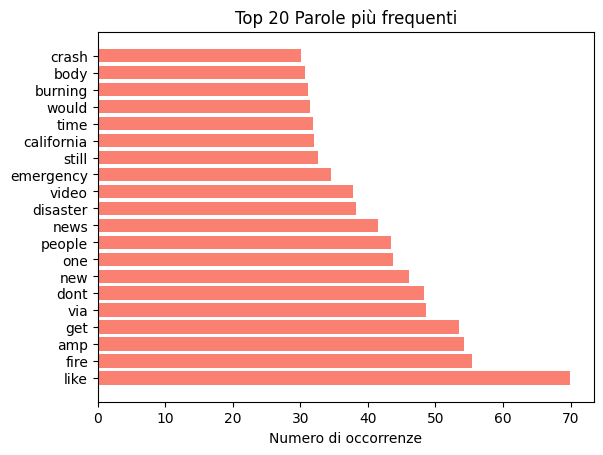

In [44]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

importanza = np.asarray(X.sum(axis=0)).flatten()
word_names = vectorizer.get_feature_names_out()

n=20
word_importance = dict(zip(word_names,importanza))
top_importance = sorted(word_importance.items(), key = lambda x: x[1], reverse=True)[:n]
df_plot = pd.DataFrame(top_importance,columns=['Parola','Frequenza'])

plt.barh(df_plot['Parola'], df_plot['Frequenza'], color='salmon')
plt.title(f'Top {n} Parole più frequenti')
plt.xlabel('Numero di occorrenze')
plt.show()

Addestramento del modello

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Inizializza il modello
model = LogisticRegression()

# Addestra il modello sui dati di training
model.fit(X_train, y_train)

# Fai una previsione sui dati di test (quelli dello split 0.2)
y_pred = model.predict(X_test)

# Controlla come è andato
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8023637557452397
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       874
           1       0.84      0.66      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523



Previsione sul vero "test.csv"


In [47]:
# 1. Carica il vero test set
real_test_df = pd.read_csv("test.csv")

# 2. Pulisci il testo con la funzione che abbiamo creato
real_test_df['text_clean'] = real_test_df['text'].apply(clean_tweet)

# 3. Trasforma in TF-IDF (usa il vectorizer già addestrato!)
X_real_test = vectorizer.transform(real_test_df['text_clean'])

# 4. Genera le previsioni finali
final_predictions = model.predict(X_real_test)

In [48]:
# Crea il DataFrame per la sottomissione
submission = pd.DataFrame({
    "id": real_test_df["id"],
    "target": final_predictions
})

# Salva in CSV
submission.to_csv("my_submission.csv", index=False)
print("File pronto per l'upload!")

File pronto per l'upload!


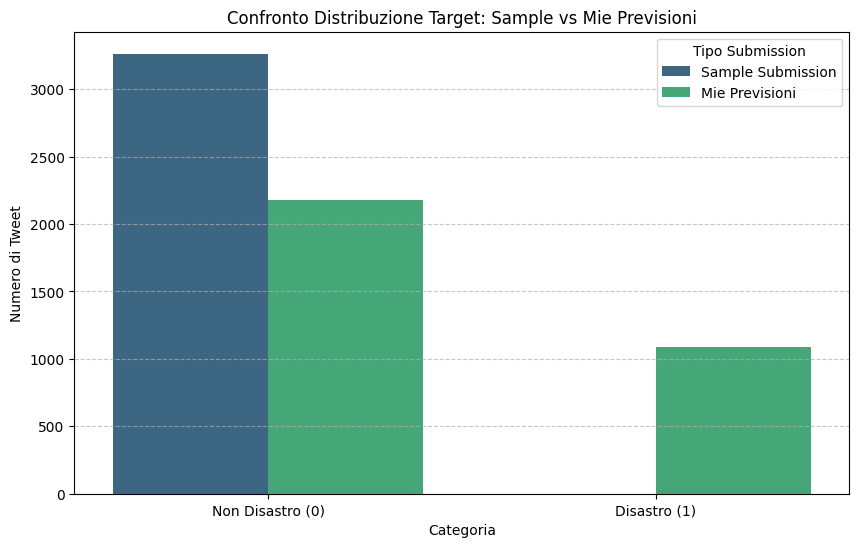

Distribuzione Sample Submission:
target
0    3263
Name: count, dtype: int64

Distribuzione Mie Previsioni:
target
0    2175
1    1088
Name: count, dtype: int64


In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Carica i due file
sample_sub = pd.read_csv('sample_submission.csv')
my_sub = pd.read_csv('my_submission.csv')

# 2. Conta quante occorrenze di 0 e 1 ci sono in entrambi
sample_counts = sample_sub['target'].value_counts().sort_index()
my_counts = my_sub['target'].value_counts().sort_index()

# 3. Prepara i dati per il grafico
df_compare = pd.DataFrame({
    'Classe': ['Non Disastro (0)', 'Disastro (1)'],
    'Sample Submission': [sample_counts.get(0, 0), sample_counts.get(1, 0)],
    'Mie Previsioni': [my_counts.get(0, 0), my_counts.get(1, 0)]
})

# Trasformiamo il dataframe in formato "long" per seaborn
df_plot = df_compare.melt(id_vars='Classe', var_name='Tipo Submission', value_name='Conteggio')

# 4. Crea il grafico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x='Classe', y='Conteggio', hue='Tipo Submission', palette='viridis')

plt.title('Confronto Distribuzione Target: Sample vs Mie Previsioni')
plt.ylabel('Numero di Tweet')
plt.xlabel('Categoria')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Stampa anche i valori numerici per precisione
print("Distribuzione Sample Submission:")
print(sample_counts)
print("\nDistribuzione Mie Previsioni:")
print(my_counts)

<Figure size 800x600 with 0 Axes>

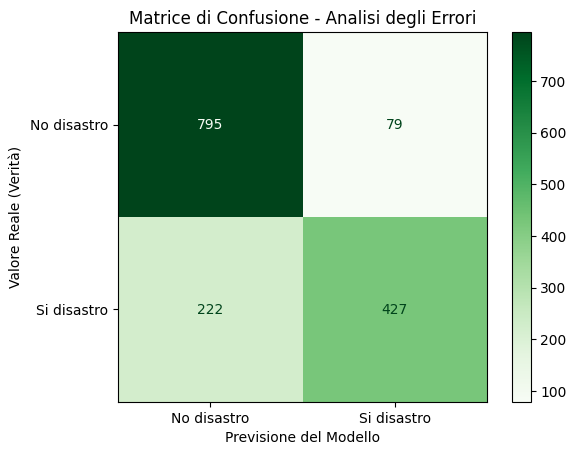

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No disastro',"Si disastro"])
disp.plot(cmap='Greens', values_format='d')
plt.title('Matrice di Confusione - Analisi degli Errori')
plt.xlabel('Previsione del Modello')
plt.ylabel('Valore Reale (Verità)')
plt.show()